### An LSTM encoder-decoder based implementation of Neural Machine Translation on German-English dataset
(https://arxiv.org/pdf/1406.1078.pdf)

In [1]:
import pandas as pd
from sklearn.metrics import mean_squared_error
import numpy as np
np.set_printoptions(precision=2)
import ipywidgets as widgets
from IPython.display import clear_output

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras.backend as K
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.callbacks import ModelCheckpoint

from nltk.translate.bleu_score import corpus_bleu
import matplotlib.pyplot as plt
import re
from unicodedata import normalize
import string
import pickle
import random

Using TensorFlow backend.


### Data Pre-processing ###

In [5]:
# Load the file to preprocess
def load_file(filename):
    '''Function to load file'''
    file = open(filename, mode='rt', encoding='utf-8')
    text = file.read()
    file.close()
    return text

def getPairs(text):
    '''Function to get eng-german keyword pairs from input text'''
    pairs = [line.strip().split('\t') for line in text.strip().split('\n')]
    return pairs

def cleanPairs(lines):
    '''Function to clean the eng-german keyword pair list and removing unprintable chars'''
    cleaned = list()
    # Regex for char filtering
    re_print = re.compile('[^%s]' % re.escape(string.printable))
    table = str.maketrans('', '', string.punctuation)
    for pair in lines:
        clean_pair = list()
        for line in pair:
#             print("line0: {0}".format(line))
            line = normalize('NFD', line).encode('ascii', 'ignore')
#             print("line1: {0}".format(line))
            line = line.decode('UTF-8')
            line = line.split()
#             print("line2: {0}".format(line))
            line = [word.lower() for word in line]
            line = [word.translate(table) for word in line]
#             print("line22: {0}".format(line))
            line = [re_print.sub('', word) for word in line]
            # Remove numeric chrs
            line = [w for w in line if w.isalpha()]
#             print("line3: {0}".format(line))
            clean_pair.append(' '.join(line))
        cleaned.append(clean_pair)
    return np.array(cleaned)

# Save the cleaned data to the given filename
def save_data(sentences, filename):
    '''Function to save save the file in pickle format'''
    pickle.dump(sentences, open(filename, 'wb'))
    print('Saved: %s' % filename)

In [7]:
filename = 'deu.txt'
file = load_file(filename)
pairs = getPairs(file)
cleaned_pairs = cleanPairs(pairs)
save_data(cleaned_pairs, 'english-german.pickle')

Saved: english-german.pickle


In [8]:
len(cleaned_pairs)

169813

### Creating train/validation/test datasets ###

In [9]:
def load_pkl_data(filename):
    '''Function to load pickle file'''
    file = open(filename, 'rb')
    return pickle.load(file)

In [10]:
raw_data = load_pkl_data('english-german.pickle')

dataset = raw_data[:10000, :]
random.shuffle(dataset)

train_set = dataset[:9000, :]
test_set = dataset[9000:, :]

save_data(dataset, 'english-german-both.pickle')
save_data(train_set, 'english-german-train.pickle')
save_data(test_set, 'english-german-test.pickle')

Saved: english-german-both.pickle
Saved: english-german-train.pickle
Saved: english-german-test.pickle


### Encoding the input/output & model training ###

In [54]:
# fit a tokenizer
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

# max sentence length
def max_length(lines):
    return max(len(line.split()) for line in lines)

# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    X = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    X = pad_sequences(X, maxlen=length, padding='post')
    return X

# one hot encode target sequence
def encode_output(sequences, vocab_size):
    ylist = list()
    for sequence in sequences:
        encoded = to_categorical(sequence, num_classes=vocab_size)
        ylist.append(encoded)
    y = np.array(ylist)
    y = y.reshape(sequences.shape[0], sequences.shape[1], vocab_size)
    return y

# Map an integer to a word
def map_int_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

# Predict the target sequence
def predict_sequence(model, tokenizer, source):
    pred = model.predict(source, verbose=0)[0]
    integers = [np.argmax(vector) for vector in pred]
    target = list()
    for i in integers:
        word = map_int_to_word(i, tokenizer)
        if word is None:
            break
        target.append(word)
    return ' '.join(target)

# Evaluate the model
def evaluate_model(model, tokenizer, source, raw_dataset, cutoff_length=2):
    predicted, actual = list(), list()
    cnt = 0
    for i, sentence in enumerate(source):
        raw_target, raw_source = raw_dataset[i]
        if(len(raw_target.split()) < cutoff_length):
            continue
        s = sentence.reshape((1, sentence.shape[0]))
        translation = predict_sequence(model, tokenizer, s)
        if cnt < 10:
            print('src=[%s], target=[%s], predicted=[%s]' % (raw_source, raw_target, translation))
        actual.append(raw_target.split())
        predicted.append(translation.split())
        cnt += 1

    # Bleu Scores
    print('Bleu-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('Bleu-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('Bleu-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('Bleu-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

# define NMT model
def define_model(src_vocab, tar_vocab, src_timesteps, tar_timesteps, n_units):
    model = Sequential()
    model.add(Embedding(src_vocab, n_units, input_length=src_timesteps, mask_zero=True))
    model.add(LSTM(n_units))
    model.add(RepeatVector(tar_timesteps))
    model.add(LSTM(n_units, return_sequences=True))
    model.add(TimeDistributed(Dense(tar_vocab, activation='softmax')))
    return model

In [12]:
class PlotLearning(keras.callbacks.Callback):
    '''Class to plot live training loss'''
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        # self.acc.append(logs.get('acc'))
        # self.val_acc.append(logs.get('val_acc'))
        self.i += 1
        f, ax1 = plt.subplots(1, 1, sharex=True, figsize=(10,6))
        clear_output(wait=True)

        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val_loss")
        ax1.legend()
        plt.show()

In [13]:
# load datasets
dataset = load_pkl_data('english-german-both.pickle')
train = load_pkl_data('english-german-train.pickle')
test = load_pkl_data('english-german-test.pickle')

# prepare english tokenizer
eng_tokenizer = create_tokenizer(dataset[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = max_length(dataset[:, 0])
print('English Vocabulary Size: %d' % eng_vocab_size)
print('English Max Length: %d' % (eng_length))

# prepare german tokenizer
ger_tokenizer = create_tokenizer(dataset[:, 1])
ger_vocab_size = len(ger_tokenizer.word_index) + 1
ger_length = max_length(dataset[:, 1])
print('German Vocabulary Size: %d' % ger_vocab_size)
print('German Max Length: %d' % (ger_length))

# prepare training data
trainX = encode_sequences(ger_tokenizer, ger_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])
trainY = encode_output(trainY, eng_vocab_size)

# prepare validation data
testX = encode_sequences(ger_tokenizer, ger_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])
testY = encode_output(testY, eng_vocab_size)

# define model
model = define_model(ger_vocab_size, eng_vocab_size, ger_length, eng_length, 256)
model.compile(optimizer='adam', loss='categorical_crossentropy')
# summarize defined model
print(model.summary())
# plot_model(model, to_file='model.png', show_shapes=True)
# fit model

English Vocabulary Size: 1564
English Max Length: 5
German Vocabulary Size: 2393
German Max Length: 8
Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 8, 256)            612608    
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               525312    
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 5, 256)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 5, 256)            525312    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 5, 1564)           401948    
Total params: 2,065,180
Trainable params: 2,065,180
Non-trainable params: 0
________________________

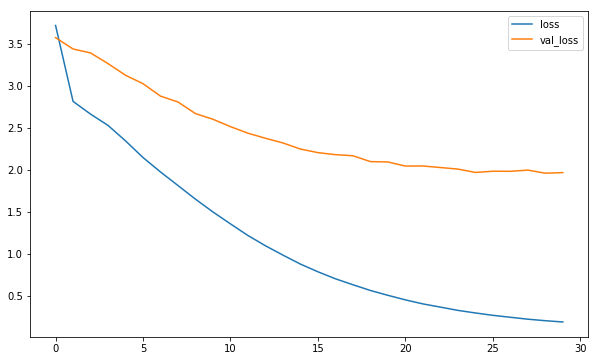

In [14]:
filename = 'model.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
model.fit(trainX, trainY, epochs=30, batch_size=64, validation_data=(testX, testY), callbacks=[checkpoint, PlotLearning()], verbose=2)

### Evaluating the model ###

In [21]:
train[:10]

array([['hi', 'hallo'],
       ['hi', 'gru gott'],
       ['run', 'lauf'],
       ['hi', 'hallo'],
       ['hi', 'hallo'],
       ['hi', 'gru gott'],
       ['hi', 'gru gott'],
       ['hi', 'hallo'],
       ['hi', 'hallo'],
       ['go on', 'mach weiter']], dtype='<U291')

In [20]:
trainX[:10]

array([[ 99,   0,   0,   0,   0,   0,   0,   0],
       [426, 298,   0,   0,   0,   0,   0,   0],
       [299,   0,   0,   0,   0,   0,   0,   0],
       [ 99,   0,   0,   0,   0,   0,   0,   0],
       [ 99,   0,   0,   0,   0,   0,   0,   0],
       [426, 298,   0,   0,   0,   0,   0,   0],
       [426, 298,   0,   0,   0,   0,   0,   0],
       [ 99,   0,   0,   0,   0,   0,   0,   0],
       [ 99,   0,   0,   0,   0,   0,   0,   0],
       [ 28,  86,   0,   0,   0,   0,   0,   0]])

In [47]:
raw_data[1]

array(['hi', 'gru gott'], dtype='<U291')

In [55]:
print('Testing on trained examples')
evaluate_model(model, eng_tokenizer, trainX, train, 1)

Testing on trained examples
src=[hallo], target=[hi], predicted=[hi]
src=[gru gott], target=[hi], predicted=[hi]
src=[lauf], target=[run], predicted=[run]
src=[hallo], target=[hi], predicted=[hi]
src=[hallo], target=[hi], predicted=[hi]
src=[gru gott], target=[hi], predicted=[hi]
src=[gru gott], target=[hi], predicted=[hi]
src=[hallo], target=[hi], predicted=[hi]
src=[hallo], target=[hi], predicted=[hi]
src=[mach weiter], target=[go on], predicted=[go on]
Bleu-1: 0.067523
Bleu-2: 0.000000
Bleu-3: 0.000000
Bleu-4: 0.000000


###### For cutoff length = 2

In [58]:
print('Testing on test examples')
evaluate_model(model, eng_tokenizer, testX, test, 2)

Testing on test examples
src=[tom fiel], target=[tom fell], predicted=[tom fell]
src=[wo ist tom], target=[wheres tom], predicted=[wheres tom]
src=[ich habe einen lkw], target=[i have a truck], predicted=[i have a truck]
src=[raus aus den federn], target=[get out of bed], predicted=[get get the]
src=[vielleicht regnet es], target=[it may rain], predicted=[it may rain]
src=[mir ist zum weinen zumute], target=[i want to cry], predicted=[hes very bored]
src=[tom ist gemein], target=[toms mean], predicted=[tom is mean]
src=[das wird ein spa], target=[thisll be fun], predicted=[nobody enjoy]
src=[sie ist auf diat], target=[shes dieting], predicted=[theyre hard]
src=[fangen wir an], target=[lets begin], predicted=[lets begin]
Bleu-1: 0.070420
Bleu-2: 0.000000
Bleu-3: 0.000000
Bleu-4: 0.000000


###### For cutoff length = 4

In [60]:
print('Testing on test examples')
evaluate_model(model, eng_tokenizer, testX, test, 4)

Testing on test examples
src=[ich habe einen lkw], target=[i have a truck], predicted=[i have a truck]
src=[raus aus den federn], target=[get out of bed], predicted=[get get the]
src=[mir ist zum weinen zumute], target=[i want to cry], predicted=[hes very bored]
src=[darf ich dich kussen], target=[can i kiss you], predicted=[can i hear you]
src=[machs wie du es fur richtig haltst], target=[do as you want], predicted=[do as you want]
src=[sie ist gerade auer haus], target=[she is out now], predicted=[she is a]
src=[hol mir mal meine werkzeugkiste], target=[get my tool box], predicted=[get me me]
src=[ich bin lehrerin], target=[i am a teacher], predicted=[im healthy]
src=[ich bin auf dem dach], target=[im on the roof], predicted=[im not by bus]
src=[das ist ein zeichen], target=[this is a sign], predicted=[thats a fake]
Bleu-1: 0.162406
Bleu-2: 0.000000
Bleu-3: 0.000000
Bleu-4: 0.000000


###### For cutoff length = 5

In [61]:
print('Testing on test examples')
evaluate_model(model, eng_tokenizer, testX, test, 5)

Testing on test examples
src=[das mussen sie wissen], target=[it is up to you], predicted=[we want to]
src=[er hat einen hut auf], target=[he has a hat on], predicted=[he looks in]
src=[ich sage tue es], target=[i say go for it], predicted=[i can you it]
src=[ich war auf einem fahrrad], target=[i was on a bike], predicted=[i was at home]
src=[das hangt von dir ab], target=[it is up to you], predicted=[its on to us]
Bleu-1: 0.111111
Bleu-2: 0.000000
Bleu-3: 0.000000
Bleu-4: 0.000000


- It can be seen as we increase the size of the input phrase, the BLEU score decreases. Hence, we can look at attention mechanisms for improvement.